# CIFAR-10 convolutional network

This is a small CIFAR-10 convolutional neural network designed to run on one
Loihi chip. Because of these size constraints, it is not particularly
powerful, and does not achieve anywhere near state-of-the-art results on the
task. Nevertheless, the network performs well enough to demonstrate that
Loihi is capable of hosting larger, more powerful object recognition networks
than MNIST.

The main libraries we'll be using in this tutorial are:

- `nengo` to create the network
- `nengo_dl` to train the network (`nengo_dl` uses `tensorflow` under the hood, so we
also import that, along with the `tensorflow_probability` extension package, to define
the loss function)
- `nengo_loihi` to run the network on the Loihi hardware (or simulate Loihi if hardware
is not available)

In [1]:
%matplotlib inline

import collections
import functools
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import nengo_loihi


def partial(func, *args, **kwargs):
    """Helper to call functools.partial and copy over func.__name__"""
    new_func = functools.partial(func, *args, **kwargs)
    functools.update_wrapper(new_func, func)
    return new_func

## Preliminaries

First, we'll make some preliminary definitions
that will help us throughout the rest of the training process.
Understanding these in detail is not necessary to understand the example,
so feel free to skip them and come back later, or ignore them completely.

We define a function called `percentile_l2_loss_range`,
which we will use to help regularize our neuron firing rates
so that they fall in our desired range.
The input `y` to our function is the firing rates of all neurons
across all examples in the batch.
We compute a percentile on these firing rates for each neuron,
across all the examples.
If this percentile is outside our desired range of `min` to `max`,
then it contributes to the squared loss.

`slice_data_dict` applies a slice to the first dimension
of all arrays in a data dictionary,
to make it easy to select a subset of data for testing.

In [2]:
def percentile_l2_loss_range(
    y_true, y, sample_weight=None, min_rate=0.0, max_rate=np.inf, percentile=99.0
):
    # y axes are (batch examples, time (==1), neurons)
    assert len(y.shape) == 3
    rates = tfp.stats.percentile(y, percentile, axis=(0, 1))
    low_error = tf.maximum(0.0, min_rate - rates)
    high_error = tf.maximum(0.0, rates - max_rate)
    loss = tf.nn.l2_loss(low_error + high_error)

    return (sample_weight * loss) if sample_weight is not None else loss


def slice_data_dict(data, slice_):
    return {key: value[slice_] for key, value in data.items()}

We also define a custom class for iterating an image dataset and returning dictionaries
that can be used by NengoDL for training. Much of this is a re-implementation of
`tf.keras.preprocessing.image.NumpyArrayIterator`, with the additional features of (a)
allowing us to return dictionaries with the provided keys, rather than just lists of
Numpy arrays, and (b) allowing multiple `y` values to be returned.

In [3]:
class NengoImageIterator(tf.keras.preprocessing.image.Iterator):
    def __init__(
        self,
        image_data_generator,
        x_keys,
        x,
        y_keys,
        y,
        batch_size=32,
        shuffle=False,
        sample_weight=None,
        seed=None,
        subset=None,
        dtype="float32",
    ):
        assert subset is None, "Not Implemented"
        assert isinstance(x_keys, (tuple, list))
        assert isinstance(y_keys, (tuple, list))
        assert isinstance(x, (tuple, list))
        assert isinstance(y, (tuple, list))

        self.dtype = dtype
        self.x_keys = x_keys
        self.y_keys = y_keys

        x0 = x[0]
        assert all(len(xx) == len(x0) for xx in x), (
            "All of the arrays in `x` should have the same length. "
            "[len(xx) for xx in x] = %s" % ([len(xx) for xx in x],)
        )
        assert all(len(yy) == len(x0) for yy in y), (
            "All of the arrays in `y` should have the same length as `x`. "
            "len(x[0]) = %d, [len(yy) for yy in y] = %s"
            % (len(x0), [len(yy) for yy in y])
        )
        assert len(x_keys) == len(x)
        assert len(y_keys) == len(y)

        if sample_weight is not None and len(x0) != len(sample_weight):
            raise ValueError(
                "`x[0]` (images tensor) and `sample_weight` "
                "should have the same length. "
                "Found: x.shape = %s, sample_weight.shape = %s"
                % (np.asarray(x0).shape, np.asarray(sample_weight).shape)
            )

        self.x = [
            np.asarray(xx, dtype=self.dtype if i == 0 else None)
            for i, xx in enumerate(x)
        ]
        if self.x[0].ndim != 4:
            raise ValueError(
                "Input data in `NumpyArrayIterator` "
                "should have rank 4. You passed an array "
                "with shape",
                self.x[0].shape,
            )

        self.y = [np.asarray(yy) for yy in y]
        self.sample_weight = (
            None if sample_weight is None else np.asarray(sample_weight)
        )
        self.image_data_generator = image_data_generator
        super().__init__(self.x[0].shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        images = self.x[0]
        assert images.dtype == self.dtype

        n = len(index_array)
        batch_x = np.zeros((n,) + images[0].shape, dtype=self.dtype)
        for i, j in enumerate(index_array):
            x = images[j]
            params = self.image_data_generator.get_random_transform(x.shape)
            x = self.image_data_generator.apply_transform(x, params)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x

        batch_x_miscs = [xx[index_array] for xx in self.x[1:]]
        batch_y_miscs = [yy[index_array] for yy in self.y]

        x_pairs = [
            (k, self.x_postprocess(k, v))
            for k, v in zip(self.x_keys, [batch_x] + batch_x_miscs)
        ]
        y_pairs = [
            (k, self.y_postprocess(k, v)) for k, v in zip(self.y_keys, batch_y_miscs)
        ]

        output = (
            collections.OrderedDict(x_pairs),
            collections.OrderedDict(y_pairs),
        )

        if self.sample_weight is not None:
            output += (self.sample_weight[index_array],)
        return output

    def x_postprocess(self, key, x):
        return x if key == "n_steps" else x.reshape((x.shape[0], 1, -1))

    def y_postprocess(self, key, y):
        return y.reshape((y.shape[0], 1, -1))

## Load the dataset

We load the CIFAR-10 dataset using TensorFlow.
The data comes as `numpy.uint8` values in the range [0, 255],
so we rescale the data to the range [-1, 1].
We create one-hot representations of the labels to use during training,
as well as "flat" versions of the data where the images are flattened into vectors.
Finally, we define an `input_shape` object that describes the image shape
in a format that Nengo can use.

One variable that occurs a number of times here is the `channels_last` option,
which can be set to `True` or `False`.
This option dictates whether the image (color) channels are stored
as the last (i.e. least-significant) index in each image (`True`),
or the first (i.e. most-significant) index (`False`).
This will also dictate how the images will be represented on Loihi,
and can have effects on the number of axons and weights required on the chip.

In [4]:
channels_last = True

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

n_classes = len(np.unique(train_y))

# TensorFlow does not include the label names, so define them manually
label_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
assert n_classes == len(label_names)

if not channels_last:
    train_x = np.transpose(train_x, (0, 3, 1, 2))
    test_x = np.transpose(test_x, (0, 3, 1, 2))

# convert the images to float32, and rescale to [-1, 1]
train_x = train_x.astype(np.float32) / 127.5 - 1
test_x = test_x.astype(np.float32) / 127.5 - 1

train_t = np.array(
    tf.one_hot(train_y, n_classes, on_value=1, off_value=0), dtype=np.float32
)
test_t = np.array(
    tf.one_hot(test_y, n_classes, on_value=1, off_value=0), dtype=np.float32
)

train_y = train_y.squeeze()
test_y = test_y.squeeze()

train_x_flat = train_x.reshape((train_x.shape[0], 1, -1))
train_t_flat = train_t.reshape((train_t.shape[0], 1, -1))

test_x_flat = test_x.reshape((test_x.shape[0], 1, -1))
test_t_flat = test_t.reshape((test_t.shape[0], 1, -1))

input_shape = nengo.transforms.ChannelShape(
    test_x[0].shape, channels_last=channels_last
)
assert input_shape.n_channels in (1, 3)
assert train_x[0].shape == test_x[0].shape == input_shape.shape

2022-01-21 12:01:04.812572: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


## Create Nengo Network

Next, we create the Nengo network that we will train to classify the data.

First, we specify some configuration parameters:
- `max_rate` is the target maximum firing rate for all ensembles.
  We pick 150 because above 150 Hz, the quantization error in
  Loihi neurons becomes significant.
- The amplitude of our neurons is chosen as `1 / max_rate`,
  so that neuron outputs are generally between 0 and 1;
  this helps to match the scaling of the initial weights.
- `rate_reg` is the amount of regularization on the firing rates.
  We pick it empirically to be
  high enough to achieve the desired firing rates during training,
  and low enough to not have a significant adverse effect on accuracy.
- The `rate_target` is the target value used in the loss functions;
  it includes the amplitude scaling, since the neuron outputs received
  by the loss functions will also include the amplitude scaling.

We also define two neuron types we will use in our model.
One is a standard `nengo.SpikingRectifiedLinear` neuron,
which we use for our input neurons that are run off-chip.
The other is a `LoihiLIF` neuron type, used for the on-chip neurons.
This type takes into account the quantization error in Loihi neurons,
so by training with this neuron type in NengoDL,
our model is better able to deal with the quantization error.

To simplify the configuration,
we define the configurable layer parameters in a list of dictionaries
called `layer_confs`.
When we create the network, we loop through these entries,
and create one layer for each dictionary.

The Nengo network has three main parts:

1. Input neurons that are run off-chip to turn the input into spikes.
   This is the first entry in `layer_confs`.
   It is a 1x1 convolutional layer with 4 filters,
   meaning that for each pixel (which has 3 color values),
   it will apply a (learned) linear transform to turn those
   3 values into 4 values,
   and then pass that into `SpikingRectifiedLinear` neurons
   to generate spikes.
   The reason we don't just use the raw color channels is that
   they can have both positive and negative values,
   and we would have to figure out a way to transform them
   to work with firing rates that can only have positive values.
   One possible transform would be to use an on/off neuron pair
   to represent each pixel,
   resulting in 6 neurons per pixel.
   Rather than force this specific encoding, though,
   we find it easier to let the system learn the encoding via
   the 1x1 convolutional layer.
   We could use a higher maximum firing rate for neurons in this layer
   (up to `1 / dt`, where `dt` is the simulation timestep),
   because these neurons are simulated off-chip and thus not subject
   to the same quantization error as on-chip neurons.
2. Convolutional and dense neural layers that are run on the chip (Loihi).
   We specify these as in a normal convolutional neural network,
   with any entry that begins with a `filters` parameter
   describing a convolutional layer,
   and any entry that begins with an `n_neurons` parameter
   describing a dense layer.
   One special parameter that we have is the `block` parameter.
   This describes the size of representation that will
   go on one "block" (i.e. Loihi core),
   in `(rows, columns, channels)` format.
   Loihi cores are limited to 1024 neurons,
   so the product of the rows, columns, and channels must be `<= 1024`.
   We also choose the block shape to minimize
   the number of input and output axons to and from each core
   (since these are also constrained on Loihi).
   Multiple filters on a core can use the same axons,
   so we try to increase the number of filters per core.
   One approach is to have each layer represent
   the entire spacial extent of the image,
   but only a fraction of the filters.
   For this network, we found that this approach was creating too many
   output axons in earlier layers in the network,
   so we decided to also split the image spatially.
   For example, in the first layer on the chip
   (the second entry in `layer_confs`),
   the shape of the image being represented is `(15, 15, 64)`
   (that is, 15 rows and columns, and 64 channels).
   We make the block shape `(8, 8, 8)`,
   which means that blocks will have to be tiled twice
   both row-wise and column-wise to represent the spatial extent of the image.
   However, the number of times we have to tile blocks
   in the channel direction (to cover all 64 channels)
   goes down, as compared with e.g. a block size of `(15, 15, 4)`,
   and the number of axons is reduced. More information on configuring the
   block size can be found
   [here](https://www.nengo.ai/nengo-loihi/tips.html#splitting-large-ensembles).
3. The final part of the network is the last layer, which collects the output.
   Like the first layer, it runs off-chip,
   and allows us to get data off the board.
   We have intentionally made the layer right before it
   (the last layer on the chip) only have 100 neurons,
   so that we only have to record from 100 neurons to get data off the chip.

As we create each layer in the network,
we print some information about the layer,
which is shown as the output to this code block.

We use the `learning_phase=True` configuration option to make sure that the
`nengo_dl` simulator always runs our neurons in rate mode (as opposed to spiking mode),
allowing us to evaluate the network as an ANN.
We will only use spiking neurons when we run the network on Loihi.

In [5]:
max_rate = 150
amp = 1.0 / max_rate
rate_reg = 1e-3
rate_target = max_rate * amp  # must be in amplitude scaled units

relu = nengo.SpikingRectifiedLinear(amplitude=amp)
chip_neuron = nengo_loihi.neurons.LoihiLIF(amplitude=amp)

layer_confs = [
    dict(
        name="input-layer",
        filters=4,
        kernel_size=1,
        strides=1,
        neuron=relu,
        on_chip=False,
    ),
    dict(name="conv-layer1", filters=64, kernel_size=3, strides=2, block=(8, 8, 16)),
    dict(name="conv-layer2", filters=72, kernel_size=3, strides=1, block=(7, 7, 8)),
    dict(name="conv-layer3", filters=256, kernel_size=3, strides=2, block=(6, 6, 12)),
    dict(name="conv-layer4", filters=256, kernel_size=1, strides=1, block=(6, 6, 24)),
    dict(name="conv-layer5", filters=64, kernel_size=1, strides=1, block=(6, 6, 24)),
    dict(name="dense-layer", n_neurons=100, block=(50,)),
    dict(name="output-layer", n_neurons=10, neuron=None, on_chip=False),
]

# Create a PresentInput process to show images from the training set sequentially.
# Each image is presented for `presentation_time` seconds.
# NOTE: this is not used during training, since we get `nengo_dl` to override the
# output of this node with the training data.
presentation_time = 0.2
present_images = nengo.processes.PresentInput(test_x_flat, presentation_time)

total_n_neurons = 0
total_n_weights = 0

with nengo.Network() as net:
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # we set the learning phase to True (training) to always use rate neurons
    nengo_dl.configure_settings(learning_phase=True)

    # add a configurable keep_history option to Probes (we'll set this
    # to False for some probes below)
    nengo_dl.configure_settings(keep_history=True)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # this sets the amount of smoothing used on the LIF neurons during training
    nengo_dl.configure_settings(lif_smoothing=0.01)

    # this allows us to set `nengo_loihi` parameters like `on_chip` and `block_shape`
    nengo_loihi.add_params(net)

    # the input node that will be used to feed in input images
    inp = nengo.Node(present_images, label="input_node")

    connections = []
    transforms = []
    layer_probes = []
    shape_in = input_shape
    x = inp
    for k, layer_conf in enumerate(layer_confs):
        layer_conf = dict(layer_conf)  # copy, so we don't modify the original
        name = layer_conf.pop("name")
        neuron_type = layer_conf.pop("neuron", chip_neuron)
        on_chip = layer_conf.pop("on_chip", True)
        block = layer_conf.pop("block", None)

        if block is not None and not channels_last:
            # move channels to first index
            block = (block[-1],) + block[:-1]

        # --- create layer transform
        if "filters" in layer_conf:
            # convolutional layer
            n_filters = layer_conf.pop("filters")
            kernel_size = layer_conf.pop("kernel_size")
            strides = layer_conf.pop("strides", 1)
            assert len(layer_conf) == 0, "Unused fields in conv layer: %s" % list(
                layer_conf
            )

            kernel_size = (
                (kernel_size, kernel_size)
                if isinstance(kernel_size, int)
                else kernel_size
            )
            strides = (strides, strides) if isinstance(strides, int) else strides

            transform = nengo.Convolution(
                n_filters=n_filters,
                input_shape=shape_in,
                kernel_size=kernel_size,
                strides=strides,
                padding="valid",
                channels_last=channels_last,
                init=nengo_dl.dists.Glorot(scale=1.0 / np.prod(kernel_size)),
            )
            shape_out = transform.output_shape

            loc = "chip" if on_chip else "host"
            n_neurons = np.prod(shape_out.shape)
            n_weights = np.prod(transform.kernel_shape)
            print(
                "%s: %s: conv %s, stride %s, output %s (%d neurons, %d weights)"
                % (
                    loc,
                    name,
                    kernel_size,
                    strides,
                    shape_out.shape,
                    n_neurons,
                    n_weights,
                )
            )
        else:
            # dense layer
            n_neurons = layer_conf.pop("n_neurons")

            shape_out = nengo.transforms.ChannelShape((n_neurons,))
            transform = nengo.Dense(
                (shape_out.size, shape_in.size),
                init=nengo_dl.dists.Glorot(),
            )

            loc = "chip" if on_chip else "host"
            n_weights = np.prod(transform.shape)
            print(
                "%s: %s: dense %d, output %s (%d neurons, %d weights)"
                % (loc, name, n_neurons, shape_out.shape, n_neurons, n_weights)
            )

        assert len(layer_conf) == 0, "Unused fields in %s: %s" % (
            [name] + list(layer_conf)
        )

        total_n_neurons += n_neurons
        total_n_weights += n_weights

        # --- create layer output (Ensemble or Node)
        assert on_chip or block is None, "`block` must be None if off-chip"

        if neuron_type is None:
            assert not on_chip, "Nodes can only be run off-chip"
            y = nengo.Node(size_in=shape_out.size, label=name)
        else:
            ens = nengo.Ensemble(shape_out.size, 1, neuron_type=neuron_type, label=name)
            net.config[ens].on_chip = on_chip
            y = ens.neurons

            if block is not None:
                net.config[ens].block_shape = nengo_loihi.BlockShape(
                    block,
                    shape_out.shape,
                )

            # add a probe so we can measure individual layer rates
            probe = nengo.Probe(y, synapse=None, label="%s_p" % name)
            net.config[probe].keep_history = False
            layer_probes.append(probe)

        conn = nengo.Connection(x, y, transform=transform)
        net.config[conn].pop_type = 32

        transforms.append(transform)
        connections.append(conn)
        x = y
        shape_in = shape_out

    output_p = nengo.Probe(x, synapse=None, label="output_p")

print("TOTAL: %d neurons, %d weights" % (total_n_neurons, total_n_weights))
assert len(layer_confs) == len(transforms) == len(connections)

host: input-layer: conv (1, 1), stride (1, 1), output (32, 32, 4) (4096 neurons, 12 weights)
chip: conv-layer1: conv (3, 3), stride (2, 2), output (15, 15, 64) (14400 neurons, 2304 weights)
chip: conv-layer2: conv (3, 3), stride (1, 1), output (13, 13, 72) (12168 neurons, 41472 weights)
chip: conv-layer3: conv (3, 3), stride (2, 2), output (6, 6, 256) (9216 neurons, 165888 weights)
chip: conv-layer4: conv (1, 1), stride (1, 1), output (6, 6, 256) (9216 neurons, 65536 weights)
chip: conv-layer5: conv (1, 1), stride (1, 1), output (6, 6, 64) (2304 neurons, 16384 weights)
chip: dense-layer: dense 100, output (100,) (100 neurons, 230400 weights)
host: output-layer: dense 10, output (10,) (10 neurons, 1000 weights)
TOTAL: 51510 neurons, 522996 weights


## Train network using NengoDL

First, we check the output of all layers with the initial parameters. This helps us to
tell whether the layers have been initialized well, or if we need to fine-tune the
initialization parameters a bit more (for example, by changing their magnitudes
slightly). Layers that have zero (or very small) output, or very large output, are
red-flags that the initialization is not good, and training may not progress well.

In [6]:
# define input and target dictionaries to pass to NengoDL
train_inputs = {inp: train_x_flat}
train_targets = {output_p: train_t_flat}

test_inputs = {inp: test_x_flat}
test_targets = {output_p: test_t_flat}
for probe in layer_probes:
    train_targets[probe] = np.zeros((train_t_flat.shape[0], 1, 0), dtype=np.float32)
    test_targets[probe] = np.zeros((test_t_flat.shape[0], 1, 0), dtype=np.float32)

In [7]:
# --- evaluate layers
with nengo_dl.Simulator(net, minibatch_size=100, progress_bar=False) as sim:
    for conf, conn in zip(layer_confs, connections):
        weights = sim.model.sig[conn]["weights"].initial_value
        print("%s: initial weights: %0.3f" % (conf["name"], np.abs(weights).mean()))

    sim.run_steps(1, data={inp: train_x_flat[:100]})

for conf, layer_probe in zip(layer_confs, layer_probes):
    out = sim.data[layer_probe][-1]
    print("%s: initial rates: %0.3f" % (conf["name"], np.mean(out)))

input-layer: initial weights: 0.354
conv-layer1: initial weights: 0.050
conv-layer2: initial weights: 0.035
conv-layer3: initial weights: 0.023
conv-layer4: initial weights: 0.054
conv-layer5: initial weights: 0.068
dense-layer: initial weights: 0.025
output-layer: initial weights: 0.122


2022-01-21 12:01:09.231395: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-01-21 12:01:09.232133: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


input-layer: initial rates: 0.368
conv-layer1: initial rates: 0.131
conv-layer2: initial rates: 0.160
conv-layer3: initial rates: 0.126
conv-layer4: initial rates: 0.136
conv-layer5: initial rates: 0.199
dense-layer: initial rates: 0.212


Since everything looks good, we go ahead and train with NengoDL.

We create an `ImageDataGenerator` that will generate augmented (shifted, rotated, and
flipped) versions of the data.

We define our loss function and metrics. Our loss function has one entry for the output
probe (`output_p`) that computes the cross-entropy on our outputs (to reduce our
classification error), and entries for each of our layer rate outputs (`layer_probes`)
that push the layer firing rates to their target ranges. The total loss is the sum of
all these individual losses.

Our metrics are organized in the same way as our losses. We measure classification error
for our output, and the 99.9th percentile firing rate for each neuron. These metrics
will be printed during training, so that we can track accuracy and firing rates to make
sure training is progressing as expected.

To speed up this example we have provided some pre-trained weights that will be
downloaded. Set `do_training = True` to run the training yourself.

In [8]:
do_training = False

checkpoint_base = "./cifar10_convnet_params"

batch_size = 256

train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    data_format="channels_last" if channels_last else "channels_first",
)
train_idg.fit(train_x)

with nengo_dl.Simulator(net, minibatch_size=batch_size) as sim:
    percentile = 99.9

    def rate_metric(_, outputs):
        # take percentile over all examples, for each neuron
        top_rates = tfp.stats.percentile(outputs, percentile, axis=(0, 1))
        return tf.reduce_mean(top_rates) / amp

    losses = collections.OrderedDict()
    metrics = collections.OrderedDict()
    loss_weights = collections.OrderedDict()

    losses[output_p] = tf.losses.CategoricalCrossentropy(from_logits=True)
    metrics[output_p] = "accuracy"
    loss_weights[output_p] = 1.0

    for probe, layer_conf in zip(layer_probes, layer_confs):
        metrics[probe] = rate_metric

        if layer_conf.get("on_chip", True):
            losses[probe] = partial(
                percentile_l2_loss_range,
                min_rate=0.5 * rate_target,
                max_rate=rate_target,
                percentile=percentile,
            )
            loss_weights[probe] = rate_reg
        else:
            losses[probe] = partial(
                percentile_l2_loss_range,
                min_rate=0,
                max_rate=rate_target,
                percentile=percentile,
            )
            loss_weights[probe] = 10 * rate_reg

    sim.compile(
        loss=losses,
        optimizer=tf.optimizers.Adam(),
        metrics=metrics,
        loss_weights=loss_weights,
    )

    if do_training:
        # --- train
        steps_per_epoch = len(train_x) // batch_size

        # Create a NengoImageIterator that will return the appropriate dictionaries
        # with augmented images. Since we are using a generator, we need to include
        # the `n_steps` parameter so that NengoDL knows how many timesteps are in
        # each example (in our case, since we just have static images, it's one).
        n = steps_per_epoch * batch_size
        n_steps = np.ones((n, 1), dtype=np.int32)
        train_data = NengoImageIterator(
            image_data_generator=train_idg,
            x_keys=[inp.label, "n_steps"],
            x=[train_x[:n], n_steps],
            y_keys=[output_p.label] + [probe.label for probe in layer_probes],
            y=[train_t[:n]]
            + [np.zeros((n, 1, 0), dtype=np.float32) for _ in layer_probes],
            batch_size=batch_size,
            shuffle=True,
        )

        n_epochs = 100

        for epoch in range(n_epochs):
            sim.fit(
                train_data,
                steps_per_epoch=steps_per_epoch,
                epochs=1,
                verbose=2,
            )

            # report test data statistics
            outputs = sim.evaluate(x=test_inputs, y=test_targets, verbose=0)
            print("Epoch %d test: %s" % (epoch, outputs))

            # save the parameters to the checkpoint
            savefile = checkpoint_base
            sim.save_params(savefile)
            print("Saved params to %r" % savefile)
    else:
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1jvP8IsdqGH2kn0OJOykJxjBsJLgk8GsY",
            "%s.npz" % checkpoint_base,
        )
        sim.load_params(checkpoint_base)
        print("Loaded params %r" % checkpoint_base)

    # copy the learned/loaded parameters back to the network, for Loihi simulator
    sim.freeze_params(net)

    # run the network on some of the train and test data to benchmark performance
    try:
        train_slice = slice(0, 1000)
        train_outputs = sim.evaluate(
            x=slice_data_dict(train_inputs, train_slice),
            y=slice_data_dict(train_targets, train_slice),
            verbose=0,
        )
        print("Final train:")
        for key, val in train_outputs.items():
            print("  %s: %s" % (key, val))

        # test_slice = slice(None)
        test_slice = slice(0, 1000)
        test_outputs = sim.evaluate(
            x=slice_data_dict(test_inputs, test_slice),
            y=slice_data_dict(test_targets, test_slice),
            verbose=0,
        )
        print("Final test:")
        for key, val in test_outputs.items():
            print("  %s: %s" % (key, val))
    except Exception as e:
        print("Could not compute ANN values on this machine: %s" % e)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Loaded params './cifar10_convnet_params'
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/home/tbekolay/Code/nengo-dl/nengo_dl/simulator.py:1921: UserWarning: Number of elements in input data (1000) is not evenly divisible by Simulator.minibatch_size (256); input data will be truncated.
  warnings.warn(


Final train: graph: build stage finished in 0:00:00                            
  loss: 0.5277098417282104
  input-layer_p_loss: 0.17015402019023895
  conv-layer1_p_loss: 3.6382644176483154
  conv-layer2_p_loss: 18.714174270629883
  conv-layer3_p_loss: 9.682263374328613
  conv-layer4_p_loss: 3.000544548034668
  conv-layer5_p_loss: 0.7379398941993713
  dense-layer_p_loss: 22.42386817932129
  output_p_loss: 0.46781125664711
  input-layer_p_rate_metric: 107.99230194091797
  conv-layer1_p_rate_metric: 91.86803436279297
  conv-layer2_p_rate_metric: 119.36709594726562
  conv-layer3_p_rate_metric: 127.50333404541016
  conv-layer4_p_rate_metric: 114.98664093017578
  conv-layer5_p_rate_metric: 114.45751953125
  dense-layer_p_rate_metric: 246.7777862548828
  output_p_accuracy: 0.8463541865348816
Final test:
  loss: 0.6979641914367676
  input-layer_p_loss: 0.00046973349526524544
  conv-layer1_p_loss: 3.684715986251831
  conv-layer2_p_loss: 17.73058319091797
  conv-layer3_p_loss: 9.43673324584961


## Run the spiking neural network on Loihi

Now, we run the spiking model on Loihi
(or in the emulator if ``nxsdk`` is not installed).
For demonstration purposes, we only run 10 examples,
but feel free to run 100 or more examples
if you wish to get a better idea of the network accuracy.

The first thing we do is remove the probes on the individual layers.
This is because probing neurons takes resources on Loihi,
and we cannot afford to probe all the neurons in the model.
The probe on the output layer will remain;
this is how we will get our results.

We also add synapses to all our connections.
This provides some filtering,
to help deal with the variability introduced
when we switch to using spiking neurons.

Before running the network,
we print some information about the blocks that have been created.
One block corresponds to one Loihi core,
so this gives us information about how much each core is being used.

In [9]:
# remove layer probes
for probe in layer_probes:
    if probe in net.probes:
        net.probes.remove(probe)

# add synapses to connections
for conn in net.all_connections:
    conn.synapse = nengo.synapses.Lowpass(0.01)

n_images = 10

sim_time = n_images * presentation_time

with nengo_loihi.Simulator(net) as sim:
    # print information about how cores are being utilized
    print("\n".join(sim.model.utilization_summary()))

    sim.run(sim_time)

LoihiBlock(<Ensemble 'conv-layer1'>[0]): 100.0% compartments, 7.1% in-axons, 35.6% out-axons, 8.1% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[1]): 100.0% compartments, 7.1% in-axons, 35.6% out-axons, 8.1% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[2]): 100.0% compartments, 7.1% in-axons, 35.6% out-axons, 8.1% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[3]): 100.0% compartments, 7.1% in-axons, 35.6% out-axons, 8.1% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[4]): 87.5% compartments, 6.2% in-axons, 31.6% out-axons, 7.4% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[5]): 87.5% compartments, 6.2% in-axons, 31.6% out-axons, 7.4% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[6]): 87.5% compartments, 6.2% in-axons, 31.6% out-axons, 7.4% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[7]): 87.5% compartments, 6.2% in-axons, 31.6% out-axons, 7.4% synapses
LoihiBlock(<Ensemble 'conv-layer1'>[8]): 87.5% compartments, 6.2% in-axons, 31.6% out-axons, 7.0% synapses
LoihiBlock(<Ensemble 'conv-layer1

Our output data is a timeseries of the output values at each timestep.
We compute the number of steps each example is shown for (`pres_steps`),
and specify the number of steps we want to use for classification
(`class_steps`, the last 30% of the presentation).
We then reshape the output to index the presentation as the first dimension,
and the timesteps in each presentation as the second dimension.
We average over the last `class_steps` of each presentation,
and take the `argmax` to figure out the predicted class.

In [10]:
pres_steps = int(presentation_time / sim.dt)
class_steps = int(0.3 * pres_steps)

output = sim.data[output_p]
output = output.reshape((n_images, pres_steps) + output[0].shape)
output = output[:, -class_steps:].mean(axis=1)
preds = np.argmax(output, axis=-1)

assert preds.shape == test_y[:n_images].shape

print("Predictions: %s" % (list(preds),))
print("Actual:      %s" % (list(test_y[:n_images]),))
error = (preds != test_y[:n_images]).mean()
print("Accuracy: %0.3f%%, Error: %0.3f%%" % (100 * (1 - error), 100 * error))

Predictions: [3, 8, 8, 0, 6, 6, 1, 6, 3, 9]
Actual:      [3, 8, 8, 0, 6, 6, 1, 6, 3, 1]
Accuracy: 90.000%, Error: 10.000%


Finally, we make a plot to show the network output over time for each example.

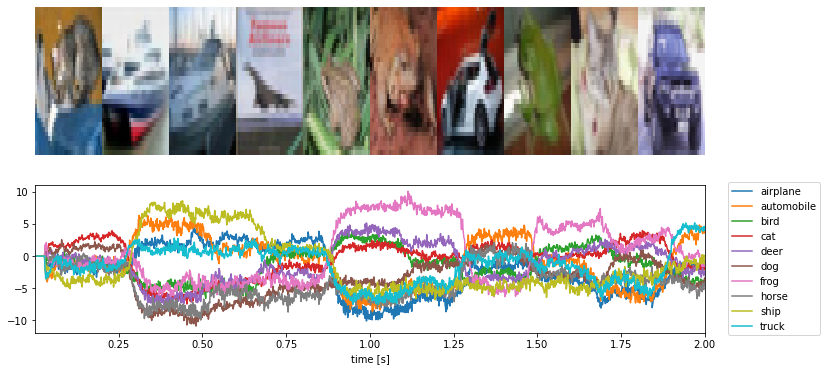

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
images = test_x if channels_last else np.transpose(test_x, (0, 2, 3, 1))
ni, nj, nc = images[0].shape
allimage = np.zeros((ni, nj * n_images, nc))
for i, image in enumerate(images[:n_images]):
    allimage[:, i * nj : (i + 1) * nj] = image
if allimage.shape[-1] == 1:
    allimage = allimage[:, :, 0]
allimage = (allimage + 1) / 2  # scale to [0, 1]
plt.imshow(allimage, aspect="auto", interpolation="none", cmap="gray")
plt.axis("off")

plt.subplot(2, 1, 2)
t = sim.trange()
plt.plot(t, sim.data[output_p])
plt.xlim([t[0], t[-1]])
plt.xlabel("time [s]")
plt.legend(label_names, loc="upper right", bbox_to_anchor=(1.18, 1.05))

We can see that we have successfully deployed the network we trained onto Loihi. As
mentioned in the introduction, this is still a simplified example designed to fit on a
single Loihi chip; we could achieve better performance with a larger model. But these
same principles should apply to deploying any deep convolutional network onto Loihi.